## Case Totvs

##### Introduction
The churn prediction is a classification problem once the response variable `is_churn` is binary. The value of `is_churn`=1 means that the customer does not purchase more from the company and `is_churn`=0 corresponds to a customer that is still a client.

##### Main goal
Customer churn analysis and model to predict if a customer could be inclined to not purchase more from the company.
##### Specific objectives
- Explore the two datasets, `orders.json` and `is_churn.json`, and extract information from the possible features (EDA)
- Develop two supervisioned machine learning models, Logistic Regression and XGBoost, wich fits with the classification problem.

### EDA

In [1]:
import pandas as pd
import numpy as np

In [2]:
orders_df = pd.read_json("./data/orders.json")
is_churn_df = pd.read_json("./data/is_churn.json")

In [3]:
orders_df.info()
is_churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204428 entries, 0 to 204427
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   customer_code     204428 non-null  int64  
 1   branch_id         204428 non-null  int64  
 2   sales_channel     204428 non-null  int64  
 3   seller_code       204428 non-null  int64  
 4   register_date     204428 non-null  object 
 5   total_price       204428 non-null  float64
 6   order_id          204428 non-null  int64  
 7   quantity          204428 non-null  int64  
 8   item_code         204428 non-null  int64  
 9   item_total_price  204428 non-null  float64
 10  unit_price        204428 non-null  float64
 11  group_code        204428 non-null  int64  
 12  segment_code      204428 non-null  int64  
dtypes: float64(3), int64(9), object(1)
memory usage: 20.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 3 columns):
 #

- First we transform the `date` object columns to a `datetime` type, it makes easily to apply operations for the column.

In [4]:
orders_df[['register_date']] = orders_df[['register_date']].apply(lambda x: pd.to_datetime(x), axis=0)
orders_df['order_yearmonth'] = orders_df['register_date'].map(lambda date: date.year*100 + date.month)
orders_df["primary_key"] = orders_df['order_id'].astype(str) + orders_df['item_code'].astype(str)
is_churn_df[['last_purchase_date']] = is_churn_df[['last_purchase_date']].apply(lambda x: pd.to_datetime(x), axis=0)

### Customers
The `orders` dataset is the source with more information, however this information is mixed between informations about the customer, informations about the customer orders and the sales/seller. In order to extract information with more clearity, I will separate the analysis in three groups:
- Customers
- Orders x Customers
- Sales x Customers
In all groups the focus is to find possible information that could explain our response variable `is_churn`.

In [5]:
## Separate customer infos from orders info
customer_infos = orders_df.sort_values(by='register_date', ascending=False).groupby(['customer_code', 'group_code', 'segment_code'])\
.first().reset_index()[['customer_code', 'group_code', 'segment_code', 'register_date']]
customer_infos.rename(columns={'register_date':'last_order_date'})
customer_infos.head()

,customer_code,group_code,segment_code,register_date
0,0,0,0,2018-06-08 00:00:00+00:00
1,1,0,0,2018-03-12 00:00:00+00:00
2,2,0,0,2018-06-28 00:00:00+00:00
3,3,0,0,2018-05-08 00:00:00+00:00
4,4,0,0,2018-01-18 00:00:00+00:00


In [6]:
all_data = is_churn_df.merge(customer_infos, how='left', on = 'customer_code')
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   customer_code       818 non-null    int64              
 1   last_purchase_date  818 non-null    datetime64[ns, UTC]
 2   is_churn            818 non-null    int64              
 3   group_code          818 non-null    int64              
 4   segment_code        818 non-null    int64              
 5   register_date       818 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int64(4)
memory usage: 38.5 KB


In [7]:
all_data.head()

,customer_code,last_purchase_date,is_churn,group_code,segment_code,register_date
0,31,2018-05-23 00:00:00+00:00,0,0,0,2018-05-23 00:00:00+00:00
1,560,2018-02-21 00:00:00+00:00,0,0,0,2018-02-21 00:00:00+00:00
2,697,2018-06-12 00:00:00+00:00,0,0,0,2018-06-12 00:00:00+00:00
3,438,2018-02-26 00:00:00+00:00,0,0,0,2018-02-26 00:00:00+00:00
4,234,2018-02-08 00:00:00+00:00,1,0,0,2018-02-08 00:00:00+00:00


In [8]:
all_data.isnull().sum()

customer_code         0
last_purchase_date    0
is_churn              0
group_code            0
segment_code          0
register_date         0
dtype: int64

In [9]:
all_data.shape

(818, 6)

In [10]:
## Check last order is the same of last purchase date
all_data.sort_values(by='register_date', ascending=False).groupby(['customer_code']).first()\
.reset_index()[['register_date','last_purchase_date']]\
.apply(lambda x: x['last_purchase_date'] - x['register_date'], axis=1)\
.sum()

Timedelta('0 days 00:00:00')

In [11]:
import seaborn as sns
%matplotlib inline

sns.set_style("white")
sns.set_palette('crest')

is_churn
0    737
1     81
Name: count, dtype: int64

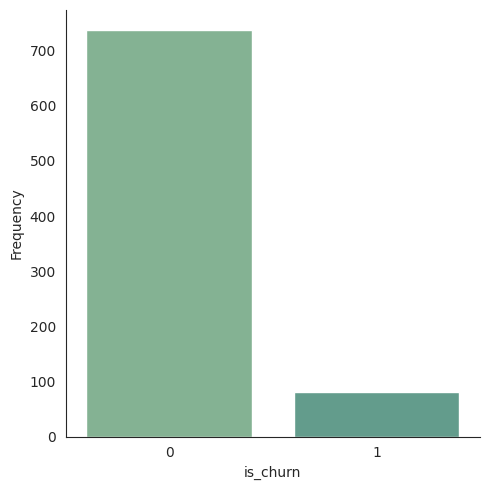

In [12]:
## `is_churn` variable in the dataset:
graf_churn = sns.catplot(x = 'is_churn', kind = 'count', data = all_data);
graf_churn.set(ylabel = 'Frequency');
all_data.is_churn.value_counts()
## Less then 10% of or data is positive for the `is_churn` variable, this can create 
## a problem to the model train and test splits.

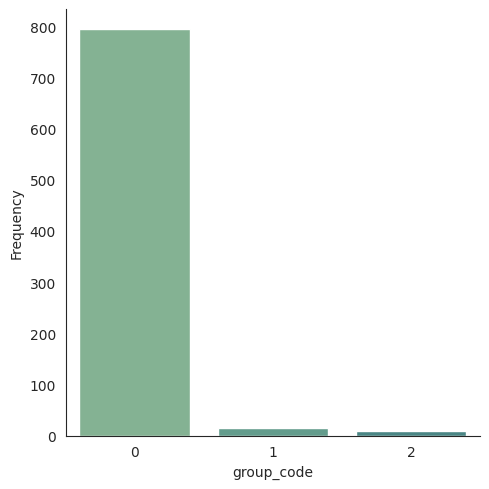

In [13]:
## Customer group
graf_churn = sns.catplot(x = 'group_code', kind = 'count', data = all_data);
graf_churn.set(ylabel = 'Frequency');

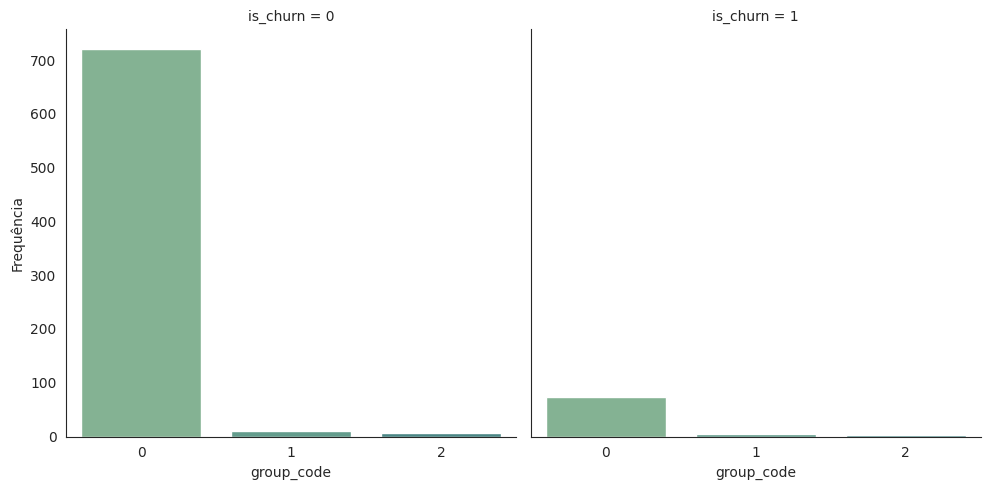

In [14]:
## The group_code 0 correspont to the majority of the customers and also the majority of the `is_churn`
graf_gen = sns.catplot(x = 'group_code', col = 'is_churn', kind = 'count', data = all_data);
graf_gen.set(ylabel = 'Frequência');

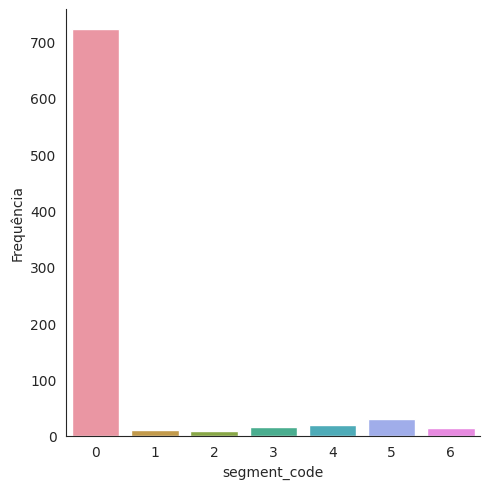

In [15]:
### Customer segment
graf_churn = sns.catplot(x = 'segment_code', kind = 'count', data = all_data);
graf_churn.set(ylabel = 'Frequência');

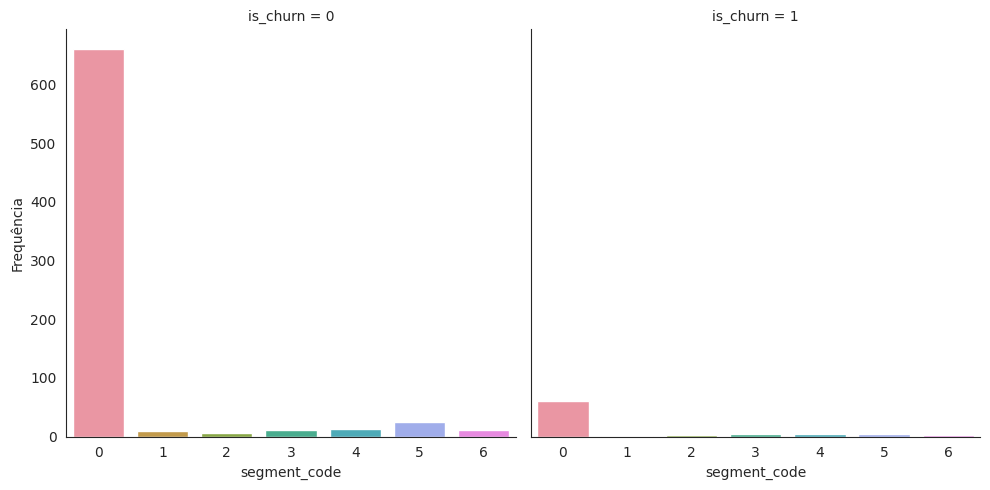

In [16]:
## The same occurs to the `segment_code` variable. The majority of customers are in the segment_code = 0
## and with mostly of the response variable.
graf_gen = sns.catplot(x = 'segment_code', col = 'is_churn', kind = 'count', data = all_data);
graf_gen.set(ylabel = 'Frequência');

### orders x customers

The `group_code` and `segment_code` bring low information about the customers churn once that the large amount of customers belongs to the same group and segments. 
The second step is extract information from the customer orders and generate insights with these values.

In [19]:
### customer orders 6 and 12 months before churn
from dateutil.relativedelta import relativedelta

date_past_6_12months = customer_infos[['customer_code', 'register_date']]
date_past_6_12months.loc[:,'6months_past_date'] = customer_infos['register_date'].map(lambda x: x-relativedelta(months=6))
date_past_6_12months.loc[:,'12months_past_date'] = date_past_6_12months['6months_past_date'].map(lambda x: x-relativedelta(months=12))


/tmp/ipykernel_509935/601951172.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_past_6_12months.loc[:,'6months_past_date'] = customer_infos['register_date'].map(lambda x: x-relativedelta(months=6))


In [20]:
date_past_6_12months.head()

,customer_code,register_date,6months_past_date,12months_past_date
0,0,2018-06-08 00:00:00+00:00,2017-12-08 00:00:00+00:00,2016-12-08 00:00:00+00:00
1,1,2018-03-12 00:00:00+00:00,2017-09-12 00:00:00+00:00,2016-09-12 00:00:00+00:00
2,2,2018-06-28 00:00:00+00:00,2017-12-28 00:00:00+00:00,2016-12-28 00:00:00+00:00
3,3,2018-05-08 00:00:00+00:00,2017-11-08 00:00:00+00:00,2016-11-08 00:00:00+00:00
4,4,2018-01-18 00:00:00+00:00,2017-07-18 00:00:00+00:00,2016-07-18 00:00:00+00:00


In [21]:
customer_revenues_past = orders_df.groupby(['order_yearmonth', 'customer_code'])['item_total_price'].sum().reset_index()\
.rename(columns={'item_total_price' : 'total_revenue'})
customer_revenues_past.head(5)

,order_yearmonth,customer_code,total_revenue
0,200801,2,2726.16
1,200801,5,2203.49
2,200801,6,1833.06
3,200801,8,17078.75
4,200801,29,788.43


In [22]:
customer_orders_past = orders_df.groupby(['order_yearmonth', 'customer_code'])['order_id'].count()\
.reset_index().rename(columns={'order_id' : 'total_orders'})
customer_orders_past.head()

,order_yearmonth,customer_code,total_orders
0,200801,2,8
1,200801,5,15
2,200801,6,9
3,200801,8,116
4,200801,29,7


In [25]:
customer_codes = []
total_orders_6m = []
total_revenues_6m = []
total_orders_12m = []
total_revenues_12m = []
for _, row in date_past_6_12months.iterrows():
    year_6month = row['6months_past_date'].year * 100 + row['6months_past_date'].month
    year_12month = row['12months_past_date'].year * 100 + row['12months_past_date'].month
    
    tmp_orders_6m = customer_orders_past[(customer_orders_past['customer_code'] == row['customer_code'])&
                                (customer_orders_past['order_yearmonth'] >= year_6month)]
    tmp_orders_12m = customer_orders_past[(customer_orders_past['customer_code'] == row['customer_code'])&
                                ((customer_orders_past['order_yearmonth'] <= year_6month)&
                                (customer_orders_past['order_yearmonth'] >= year_12month))]
    tmp_revenues_6m = customer_revenues_past[(customer_revenues_past['customer_code'] == row['customer_code'])&
                                (customer_revenues_past['order_yearmonth'] >= year_6month)]
    tmp_revenues_12m = customer_revenues_past[(customer_revenues_past['customer_code'] == row['customer_code'])&
                                ((customer_revenues_past['order_yearmonth'] <= year_6month)&
                                (customer_revenues_past['order_yearmonth'] >= year_12month))]
    customer_codes.append(row['customer_code'])
    total_orders_6m.append(tmp_orders_6m['total_orders'].sum())
    total_revenues_6m.append(tmp_revenues_6m['total_revenue'].sum())
    total_orders_12m.append(tmp_orders_12m['total_orders'].sum())
    total_revenues_12m.append(tmp_revenues_12m['total_revenue'].sum())
past6m_12m_revenue_orders = pd.DataFrame({'customer_code':customer_codes,
                                    'total_orders_6m':total_orders_6m,
                                     'total_orders_12m':total_orders_12m,
                                     'total_revenue_6m':total_revenues_6m,
                                    'total_revenue_12m':total_revenues_12m})
past6m_12m_revenue_orders.head()

,customer_code,total_orders_6m,total_orders_12m,total_revenue_6m,total_revenue_12m
0,0,25,26,8481.39,17665.65
1,1,21,31,4689.84,6780.03
2,2,24,43,5977.61,11719.95
3,3,13,44,16478.82,23332.12
4,4,10,12,2548.56,2925.89


def get_change(current, previous):
    if current == previous:
        return 0
    if previous == 0:
        return 1
    return (abs(current - previous) / previous)


In [26]:
def get_change(current, previous):
    if current == previous:
        return 0
    if previous == 0:
        return 1
    return previous - current

In [27]:
past6m_12m_revenue_orders['last_sem_revenue_diff'] = past6m_12m_revenue_orders.apply(lambda x: get_change(x['total_revenue_6m'], x['total_revenue_12m']), axis=1)
past6m_12m_revenue_orders['last_sem_orders_diff'] = past6m_12m_revenue_orders.apply(lambda x: get_change(x['total_orders_6m'], x['total_orders_12m']), axis=1)
past6m_12m_revenue_orders.head()

,customer_code,total_orders_6m,total_orders_12m,total_revenue_6m,total_revenue_12m,last_sem_revenue_diff,last_sem_orders_diff
0,0,25,26,8481.39,17665.65,9184.26,1.0
1,1,21,31,4689.84,6780.03,2090.19,10.0
2,2,24,43,5977.61,11719.95,5742.34,19.0
3,3,13,44,16478.82,23332.12,6853.30,31.0
4,4,10,12,2548.56,2925.89,377.33,2.0


In [28]:
all_data = all_data.merge(past6m_12m_revenue_orders, how='left', on = 'customer_code')

In [29]:
all_data.head()

,customer_code,last_purchase_date,is_churn,group_code,segment_code,register_date,total_orders_6m,total_orders_12m,total_revenue_6m,total_revenue_12m,last_sem_revenue_diff,last_sem_orders_diff
0,31,2018-05-23 00:00:00+00:00,0,0,0,2018-05-23 00:00:00+00:00,37,57,6130.84,10622.81,4491.97,20.0
1,560,2018-02-21 00:00:00+00:00,0,0,0,2018-02-21 00:00:00+00:00,13,19,4468.68,5969.50,1500.82,6.0
2,697,2018-06-12 00:00:00+00:00,0,0,0,2018-06-12 00:00:00+00:00,24,14,7425.31,4793.38,-2631.93,-10.0
3,438,2018-02-26 00:00:00+00:00,0,0,0,2018-02-26 00:00:00+00:00,7,0,753.62,0.00,1.00,1.0
4,234,2018-02-08 00:00:00+00:00,1,0,0,2018-02-08 00:00:00+00:00,36,39,47617.64,42218.18,-5399.46,3.0


In [30]:
all_data.isnull().sum()

customer_code            0
last_purchase_date       0
is_churn                 0
group_code               0
segment_code             0
register_date            0
total_orders_6m          0
total_orders_12m         0
total_revenue_6m         0
total_revenue_12m        0
last_sem_revenue_diff    0
last_sem_orders_diff     0
dtype: int64

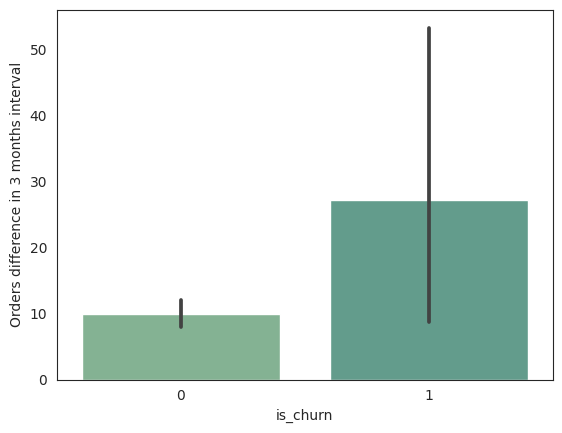

In [34]:
## Histogram to avaliate the orders difference between churn variable.
graph_orders = sns.barplot( x = 'is_churn',y = 'last_sem_orders_diff', data = all_data);
graph_orders.set(ylabel = 'Orders difference in 6 months interval');

In [35]:
all_data[['last_sem_revenue_diff', 'is_churn']].groupby('is_churn').describe()

last_sem_revenue_diff                                           
                         count          mean            std        min   
is_churn                                                                 
0                        737.0   1966.983433    6915.154206 -102761.84  \
1                         81.0  19319.019877  104833.829047  -30505.08   

                                                
              25%      50%      75%        max  
is_churn                                        
0         -186.91  1427.39  3758.81   57409.59  
1        -1249.34     1.00  5076.12  894977.79

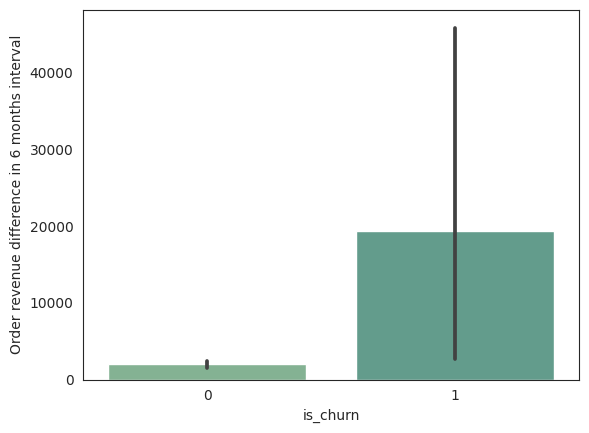

In [36]:
graf_churn = sns.barplot(x = 'is_churn', y='last_sem_revenue_diff', data = all_data);
graf_churn.set(ylabel = 'Order revenue difference in 6 months interval');

The idea is to colect two pieces of information in time. First we colect the first semester (current) from the last order that a customer made. After that, we collect the information about the past semester of the first step (previous), with that we have two separete information among 1 year. 
The propose of this is the hypothesis that if a customer expent/ordered is different between the semesters, this could indicate a tendence for churn, as showed in graphics above.

### sales x customers
Another hypothesis is that the `sales_channel` can be a indicator for a customer churn. Once that the customer uses the `sales_channel`, `sales_brand` and `seller_code` in an order, these variables could have influence in the customer decision to end a contract or not.

In [37]:
## check the last month order sale information
sales_data = orders_df.sort_values(by='register_date', ascending=False).groupby(['customer_code']).first()\
.reset_index()[['customer_code','branch_id','sales_channel', 'seller_code']]
sales_data.head()

,customer_code,branch_id,sales_channel,seller_code
0,0,0,0,153
1,1,0,0,154
2,2,0,0,224
3,3,0,0,134
4,4,0,0,3


In [38]:
all_data = all_data.merge(sales_data, how='left', on = 'customer_code')

In [39]:
all_data.head()

,customer_code,last_purchase_date,is_churn,group_code,segment_code,register_date,total_orders_6m,total_orders_12m,total_revenue_6m,total_revenue_12m,last_sem_revenue_diff,last_sem_orders_diff,branch_id,sales_channel,seller_code
0,31,2018-05-23 00:00:00+00:00,0,0,0,2018-05-23 00:00:00+00:00,37,57,6130.84,10622.81,4491.97,20.0,0,0,181
1,560,2018-02-21 00:00:00+00:00,0,0,0,2018-02-21 00:00:00+00:00,13,19,4468.68,5969.50,1500.82,6.0,0,0,119
2,697,2018-06-12 00:00:00+00:00,0,0,0,2018-06-12 00:00:00+00:00,24,14,7425.31,4793.38,-2631.93,-10.0,0,0,27
3,438,2018-02-26 00:00:00+00:00,0,0,0,2018-02-26 00:00:00+00:00,7,0,753.62,0.00,1.00,1.0,0,0,38
4,234,2018-02-08 00:00:00+00:00,1,0,0,2018-02-08 00:00:00+00:00,36,39,47617.64,42218.18,-5399.46,3.0,0,0,27


In [46]:
all_data.groupby(['branch_id'])['is_churn'].sum()

branch_id
0    81
Name: is_churn, dtype: int64

In [47]:
all_data.groupby(['sales_channel'])['is_churn'].sum()

sales_channel
0     58
1      0
2      4
6     17
7      1
10     1
14     0
Name: is_churn, dtype: int64

In [49]:
all_data.groupby(['seller_code'])['is_churn'].sum().describe()

count    137.000000
mean       0.591241
std        0.879127
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        4.000000
Name: is_churn, dtype: float64

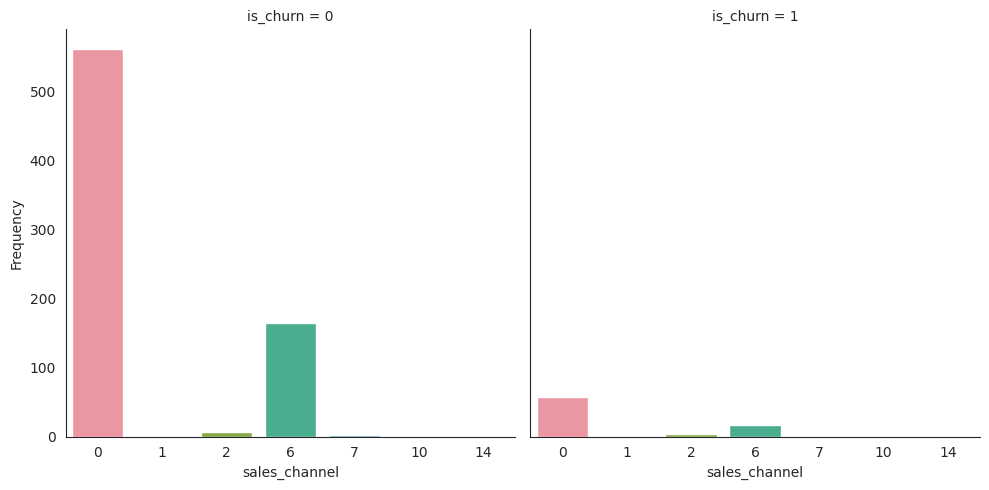

In [41]:
graf_gen = sns.catplot(x = 'sales_channel', col = 'is_churn', kind = 'count', data = all_data);
graf_gen.set(ylabel = 'Frequency');

The variance between categories for `branch_id` and `seller_code` is almost inexistent, the only possible category variable correlated with the sales that contains some information about the response variable is the `sales_channel` variable, with mostly of the information concentrated in the 0 and 6 channels.

In [50]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   customer_code          818 non-null    int64              
 1   last_purchase_date     818 non-null    datetime64[ns, UTC]
 2   is_churn               818 non-null    int64              
 3   group_code             818 non-null    int64              
 4   segment_code           818 non-null    int64              
 5   register_date          818 non-null    datetime64[ns, UTC]
 6   total_orders_6m        818 non-null    int64              
 7   total_orders_12m       818 non-null    int64              
 8   total_revenue_6m       818 non-null    float64            
 9   total_revenue_12m      818 non-null    float64            
 10  last_sem_revenue_diff  818 non-null    float64            
 11  last_sem_orders_diff   818 non-null    float64            

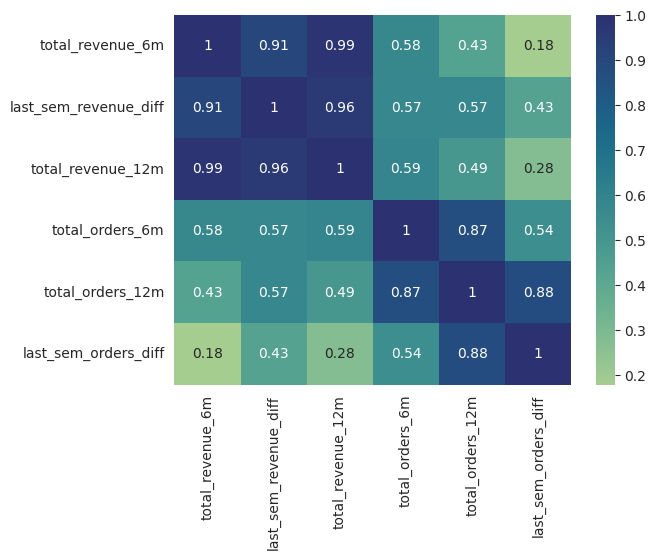

In [52]:
## Correlation analyses to avaliate the quantitative variables that could be user for our models.
correlacoes = all_data[['total_revenue_6m', 'last_sem_revenue_diff', 'total_revenue_12m',
                        'total_orders_6m', 'total_orders_12m','last_sem_orders_diff']].corr().round(3)
sns.heatmap(correlacoes, cmap = 'crest', annot = True);

## The source of information - that generate the quantitative variables above - are the same, which explains the
## great correlation between them. However is still possible to separate some variables that show reasonable correlation.
## One possible explanation is the difference between the values of the items, which could explain that orders is 
## not directly correlated with total paid value.

In [53]:
### Categorical to dummy
### Note: because some of the channels in sale do not have much information we grouped in 'others' category
all_data['segment_code_categorical'] = all_data['segment_code'].map(lambda x: 'segment_code_{}'.format(x))
all_data['sales_channel_categorical'] = all_data['sales_channel'].map(lambda x: 'sales_channel_{}'.format(x) if x in [0, 6] else 'sales_channel_others')

In [54]:
all_data.sales_channel_categorical.value_counts()

sales_channel_categorical
sales_channel_0         620
sales_channel_6         181
sales_channel_others     17
Name: count, dtype: int64

In [55]:
dummies_df = pd.get_dummies(all_data[['segment_code_categorical', 'sales_channel_categorical']])+0
dummies_df.head()

,segment_code_categorical_segment_code_0,segment_code_categorical_segment_code_1,segment_code_categorical_segment_code_2,segment_code_categorical_segment_code_3,segment_code_categorical_segment_code_4,segment_code_categorical_segment_code_5,segment_code_categorical_segment_code_6,sales_channel_categorical_sales_channel_0,sales_channel_categorical_sales_channel_6,sales_channel_categorical_sales_channel_others
0,1,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,1,0,0


In [56]:
all_data = pd.concat([all_data, dummies_df], axis=1)


In [57]:
all_data.head()

,customer_code,last_purchase_date,is_churn,group_code,segment_code,register_date,total_orders_6m,total_orders_12m,total_revenue_6m,total_revenue_12m,...,segment_code_categorical_segment_code_0,segment_code_categorical_segment_code_1,segment_code_categorical_segment_code_2,segment_code_categorical_segment_code_3,segment_code_categorical_segment_code_4,segment_code_categorical_segment_code_5,segment_code_categorical_segment_code_6,sales_channel_categorical_sales_channel_0,sales_channel_categorical_sales_channel_6,sales_channel_categorical_sales_channel_others
0,31,2018-05-23 00:00:00+00:00,0,0,0,2018-05-23 00:00:00+00:00,37,57,6130.84,10622.81,...,1,0,0,0,0,0,0,1,0,0
1,560,2018-02-21 00:00:00+00:00,0,0,0,2018-02-21 00:00:00+00:00,13,19,4468.68,5969.50,...,1,0,0,0,0,0,0,1,0,0
2,697,2018-06-12 00:00:00+00:00,0,0,0,2018-06-12 00:00:00+00:00,24,14,7425.31,4793.38,...,1,0,0,0,0,0,0,1,0,0
3,438,2018-02-26 00:00:00+00:00,0,0,0,2018-02-26 00:00:00+00:00,7,0,753.62,0.00,...,1,0,0,0,0,0,0,1,0,0
4,234,2018-02-08 00:00:00+00:00,1,0,0,2018-02-08 00:00:00+00:00,36,39,47617.64,42218.18,...,1,0,0,0,0,0,0,1,0,0


In [103]:
all_data.to_csv("./data/all_data.csv", sep="\t")

In [81]:
dados = all_data[[
           'sales_channel_categorical_sales_channel_0',
           'sales_channel_categorical_sales_channel_6',
            'last_sem_revenue_diff',
             'total_orders_12m',
            'total_orders_6m',
            'is_churn']]

dados['is_churn'] = pd.to_numeric(dados['is_churn'], downcast = 'float')

dados.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sales_channel_categorical_sales_channel_0,sales_channel_categorical_sales_channel_6,last_sem_revenue_diff,total_orders_12m,total_orders_6m,is_churn
0,1,0,4491.97,57,37,0.0
1,1,0,1500.82,19,13,0.0
2,1,0,-2631.93,14,24,0.0
3,1,0,1.00,0,7,0.0
4,1,0,-5399.46,39,36,1.0


In [82]:
#### Test and train sets ####

churn = dados.is_churn.copy()
dados = dados.drop(['is_churn'], axis = 1)

from sklearn.model_selection import train_test_split

## Because the proportion of variable `is_churn` is not the same, we use the `stratify` parameter to split the set
## with equal proportion between train and test.
X_train, X_test, y_train, y_test = train_test_split(dados,
                                                    churn,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify = churn)

In [83]:
X_train.shape

(613, 5)

In [84]:
X_test.shape

(205, 5)

In [85]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, log_loss
import statsmodels.api as sm

In [86]:
dados.head()

,sales_channel_categorical_sales_channel_0,sales_channel_categorical_sales_channel_6,last_sem_revenue_diff,total_orders_12m,total_orders_6m
0,1,0,4491.97,57,37
1,1,0,1500.82,19,13
2,1,0,-2631.93,14,24
3,1,0,1.00,0,7
4,1,0,-5399.46,39,36


##### Logistic notebooks references
To select the features used in the models it was necessary to iterate above the features groups in order to choose the best ones using the logistic regression model and summary. The references of iteration can be read in the follow:
- [iterations](./tests_log_variables.ipynb)

### Logistic Regression

In [87]:
logistic_method = sm.Logit(churn,dados)
result_log = logistic_method.fit()
print(result_log.summary2())

Optimization terminated successfully.
         Current function value: 0.303060
         Iterations 8
                                      Results: Logit
Model:                       Logit                    Method:                   MLE       
Dependent Variable:          is_churn                 Pseudo R-squared:         0.062     
Date:                        2023-05-18 18:03         AIC:                      505.8060  
No. Observations:            818                      BIC:                      529.3403  
Df Model:                    4                        Log-Likelihood:           -247.90   
Df Residuals:                813                      LL-Null:                  -264.16   
Converged:                   1.0000                   LLR p-value:              1.5079e-06
No. Iterations:              8.0000                   Scale:                    1.0000    
------------------------------------------------------------------------------------------
                          

In [88]:
## k-Fold Cross-Validation.
## k = 10.

kfold = KFold(n_splits = 10)
model_CV = LogisticRegression(solver = 'liblinear', class_weight = "balanced", random_state = 10)
medida = 'roc_auc'
resultado = cross_val_score(model_CV, X_train, y_train, cv = kfold, scoring = medida)

print('AUC: %.2f' % (resultado.mean()))

AUC: 0.67


AUC is a measure that represents the level of separability of the model. This measure indicates how much the model is able to distinguish between classes. The higher the AUC, the better the model is at correctly classifying the observations, i.e., the model will be able to classify 0 as 0 and 1 as 1.

The logistic regression model validation process returned AUC equal to 67%. Out of 100 observations, 67 are classified correctly in the train dataset.

Another important measurement related to the confusion matrix is precision. Of the customers predicted to churn, those that were correctly classified make up the accuracy measure.

In [104]:
model_CV.fit(X_train, y_train)
y_pred = model_CV.predict(X_test)
print('Classification accuracy in the test set: {:.2f}'.format(model_CV.score(X_test, y_test)))

Classification accuracy in the test set: 0.79


Besides teh AUC measure was not the best, when we confront the logistic regression model with the test dataset we achieve a more interest result of 79% of accuracy.

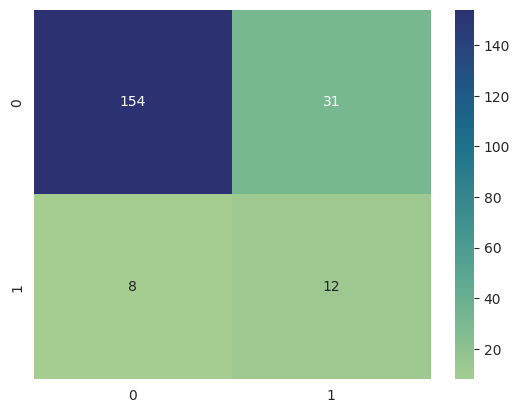

In [90]:
## Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "crest", fmt = 'g');

According to the confusion matrix, the logistic regression model correctly classified 154 customers as non-churn and 12 customers as churn, out of a total of 205 observations. The classification accuracy in the test set is equal to 79%.
It is also possible to calculate the probability associated with each customer ranking in churn or not churn, as done below. This measure is important as it allows identifying customers who are more likely to churn.

In [105]:
## Probability associated with each customer.
model_CV.fit(X_train, y_train)

## Probability of the customer being churn:
probs = model_CV.predict_proba(X_test)
probs = probs[:, 1]
probs

array([0.35381004, 0.6641809 , 0.50069504, 0.42427889, 0.63591353,
       0.53353733, 0.44942511, 0.42349687, 0.43796573, 0.54571782,
       0.5144672 , 0.36135909, 0.37322847, 0.52467808, 0.52648074,
       0.51640514, 0.45531605, 0.46226318, 0.43590576, 0.42918129,
       0.38100546, 0.37722804, 0.38656678, 0.43547362, 0.3831077 ,
       0.35482751, 0.8382655 , 0.83276405, 0.45308568, 0.67353543,
       0.42093572, 0.41468264, 0.64971171, 0.25789532, 0.38156498,
       0.56753712, 0.46056983, 0.4580095 , 0.4637052 , 0.38140827,
       0.47614482, 0.52454607, 0.37475397, 0.32587677, 0.43549086,
       0.47969607, 0.46211241, 0.42094237, 0.42142606, 0.51233435,
       0.48973663, 0.37220888, 0.45367835, 0.44356423, 0.45572785,
       0.46138216, 0.37296946, 0.43049439, 0.45829982, 0.42987999,
       0.37616203, 0.47696825, 0.49062646, 0.36507352, 0.41005898,
       0.45054596, 0.43405604, 0.44472161, 0.46621876, 0.53520094,
       0.53732425, 0.49017604, 0.39861256, 0.46888729, 0.42846

In [106]:
## AUC calculation considering the test set and predicted probabilities:
logit_roc_auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % logit_roc_auc)

AUC: 0.68


### XGBoost
The `XGBoost` machine learning algorithm consist in the idea to create multiple decision trees in order to predict the label of the response variable. The major idea consists in create "weak" decision tree models that isolated are not good, however with the **gradient boost** of the algorithm, these "weak" models are combined to evolve to a more robust final model.

[reference](https://www.nvidia.com/en-us/glossary/data-science/xgboost/)

In [93]:
import xgboost as xgb

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dados,
                                                    churn,
                                                    test_size = 0.25,
                                                    random_state = 5,
                                                    stratify = churn)

In [94]:

parametros = {'objective': 'binary:logistic', 'max_depth': 5}
dmatrix_train = xgb.DMatrix(data = X_train, label = y_train)
cv_xgboost = xgb.cv(dtrain = dmatrix_train, params = parametros, metrics = 'logloss', nfold = 10, seed = 10)

In [95]:
cv_xgboost

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.498925,0.002726,0.513481,0.012135
1,0.390746,0.003936,0.415202,0.020294
2,0.321780,0.004651,0.355791,0.029989
3,0.276162,0.005919,0.318901,0.038137
4,0.244059,0.006903,0.296414,0.044232
5,0.219951,0.007131,0.283263,0.052515
6,0.203337,0.008394,0.276741,0.058006
7,0.191248,0.008816,0.271030,0.062970
8,0.179852,0.008031,0.268307,0.067982
9,0.170344,0.007697,0.266317,0.071764


In [96]:
## Métrica final:
round(cv_xgboost['test-logloss-mean'].tail(1),2)

9    0.27
Name: test-logloss-mean, dtype: float64

In [97]:
## Como se trata de um problema de classificação, deve-se utilizar o XGBClassifier().
xgb_model = xgb.XGBClassifier(max_depth = 5, objective = 'binary:logistic', n_jobs = -1,
                             use_label_encoder = False, eval_metric = 'logloss')
xgb_model.fit(X_train, y_train, eval_set = [(X_test, y_test)])

[0]	validation_0-logloss:0.50412
[1]	validation_0-logloss:0.40321
[2]	validation_0-logloss:0.34230
[3]	validation_0-logloss:0.30403
[4]	validation_0-logloss:0.28241
[5]	validation_0-logloss:0.27039
[6]	validation_0-logloss:0.26065
[7]	validation_0-logloss:0.25666
[8]	validation_0-logloss:0.25432
[9]	validation_0-logloss:0.24966
[10]	validation_0-logloss:0.24803
[11]	validation_0-logloss:0.24873
[12]	validation_0-logloss:0.24773
[13]	validation_0-logloss:0.25025
[14]	validation_0-logloss:0.25224
[15]	validation_0-logloss:0.25179
[16]	validation_0-logloss:0.25067
[17]	validation_0-logloss:0.25394
[18]	validation_0-logloss:0.25407
[19]	validation_0-logloss:0.25514
[20]	validation_0-logloss:0.25693
[21]	validation_0-logloss:0.25681
[22]	validation_0-logloss:0.25813
[23]	validation_0-logloss:0.26124
[24]	validation_0-logloss:0.26211
[25]	validation_0-logloss:0.26126
[26]	validation_0-logloss:0.26173
[27]	validation_0-logloss:0.26308
[28]	validation_0-logloss:0.26455
[29]	validation_0-loglos

`use_label_encoder` is deprecated in 1.7.0.


[31]	validation_0-logloss:0.26364
[32]	validation_0-logloss:0.26218
[33]	validation_0-logloss:0.26198
[34]	validation_0-logloss:0.26641
[35]	validation_0-logloss:0.26700
[36]	validation_0-logloss:0.27109
[37]	validation_0-logloss:0.27001
[38]	validation_0-logloss:0.26923
[39]	validation_0-logloss:0.26900
[40]	validation_0-logloss:0.27059
[41]	validation_0-logloss:0.27003
[42]	validation_0-logloss:0.26982
[43]	validation_0-logloss:0.26920
[44]	validation_0-logloss:0.26990
[45]	validation_0-logloss:0.27219
[46]	validation_0-logloss:0.27359
[47]	validation_0-logloss:0.27350
[48]	validation_0-logloss:0.27451
[49]	validation_0-logloss:0.27649
[50]	validation_0-logloss:0.27738
[51]	validation_0-logloss:0.27711
[52]	validation_0-logloss:0.27738
[53]	validation_0-logloss:0.27915
[54]	validation_0-logloss:0.28023
[55]	validation_0-logloss:0.28196
[56]	validation_0-logloss:0.28161
[57]	validation_0-logloss:0.28233
[58]	validation_0-logloss:0.28362
[59]	validation_0-logloss:0.28670
[60]	validatio

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [107]:
round(xgb_model.score(X_train, y_train), 2)

1.0

In [108]:
round(xgb_model.score(X_test[X_train.columns], y_test), 2)

0.91

The accuracy of XGBoost is 100% for our train set and 91% for the test set. The first one indicates that the model overfit with the dataset, maybe because of the nature of the algorithm, the lack of inputs to the multiple decision trees generated could create this overfit result.

Eventhoug the 91% of accuracy in the test set, when we check the confusion matrix we can notice that the model is less precise for churn customers than or logistic regression model, the model apperantly is more precise to just confirm that a customer will not convert to churn.

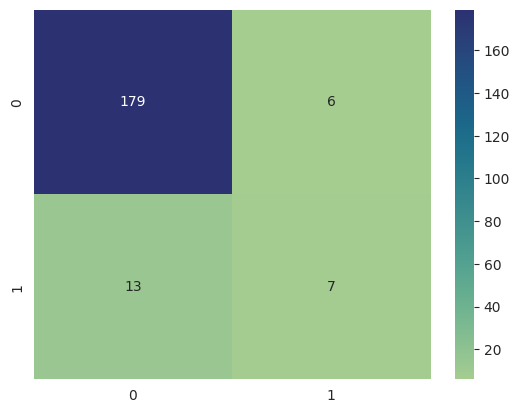

In [100]:
## Confusion Matrix
y_pred = xgb_model.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "crest", fmt = 'g');

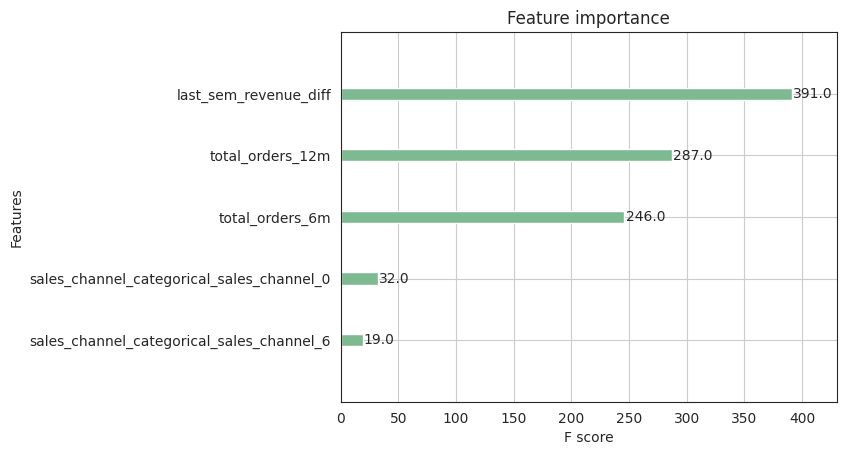

In [101]:
from xgboost import plot_importance
plot_importance(xgb_model);

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


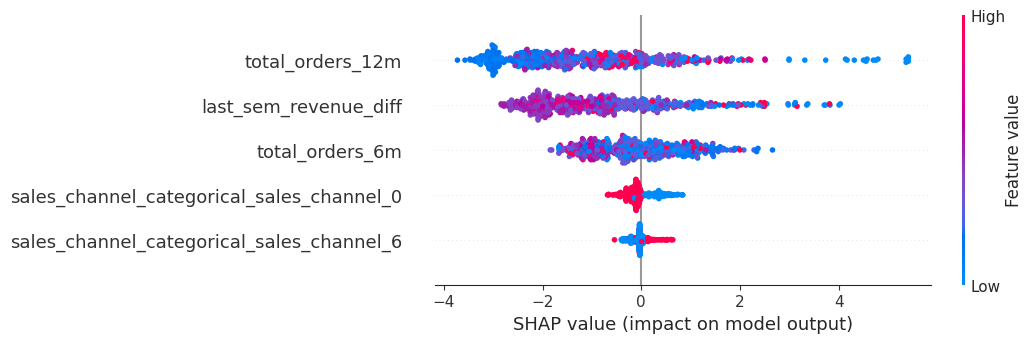

In [102]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
shap_obj = explainer(X_train)
shap.plots.beeswarm(shap_obj)

### Conclusions

Together with the exploratory analysis of the data, the results of the models guide a possible profile for customers that could churn in time. This information could be used to improve the marketing or sales strategy to retain clients.

On one side, the logistic regression is more precise to predict the customers that are more likely to churn and the XGBoost apparently is more accurate to predict customers that will not cancel a contract.

Despite the model's performances, some points could be highlighted. The logistic regression model is more likely to use the information that is more abundant in the datasets, which is, the information about the orders behaviour of the customer. Different kinds of combinations using these data could be performed in order to tune the model, with the benefit that is a model that is easy to understand and interpret.

It is noteworthy that the development of the predictive solution is a process of continuous testing. Nothing prevents the results of the models from being used together, each in its own scope. In addition, it is possible that the presented models are improved through the adjustment parameters. Therefore, the predictive capacity can still increase in both cases.

Another possible highlight in the analyses is the importance that just a few set of variables has in the variable response. Such as:
- **group_code & segment_code:** 
 
The majority of the data for both possible classifications (`is_churn`=[1,0]) are concentrated in the customer group and segment equal to 0. This information could be used as a business strategy to maybe expand the groups and segments that the company sell.

- **sales_channel:** 

The sales_channel variable is another variable that is concentrated when we look at the response of the customer be a churn or not. Maybe the business could look more carefully at these channels and understand why they have this kind of response from the customer.